# 1. Makte templates

In [2]:
import pandas as pd

data = pd.read_parquet("../data/dataset/reddit+shsyt/data.parquet").drop_duplicates(subset="id")
data["yt_id"] = data.id.apply(lambda x: x.split("_", 1)[1])

data["has_WoA"] = data.IOB.apply(lambda x: "B-WoA" in x)
data["has_Artist"] = data.IOB.apply(lambda x: "B-Artist" in x)
data_template = data[data.has_WoA | data.has_Artist]
data_template = data_template[data_template.IOB.apply(lambda x: "O" in x)]


In [3]:
import re

def process_iob_text(data, iob_col='IOB', text_col='TEXT'):
    def process_sequence(iob_tags, text_tokens):
        processed_iob = []
        processed_text = []
        current_class = None

        for iob, token in zip(iob_tags, text_tokens):
            if iob.startswith('B-'):
                current_class = iob[2:]  # Get the class name after 'B-'
                processed_iob.append(current_class)
                processed_text.append(f'[{current_class}]')
            elif iob.startswith('I-') and current_class:
                # Continue the current class, but skip it in output
                continue
            else:
                # It's an 'O' tag or something else
                current_class = None
                processed_iob.append('O')
                processed_text.append(token)
        
        return processed_iob, processed_text

    # Apply the process_sequence function row-wise
    data[['IOB_template', 'TEXT_template']] = data.apply(
        lambda row: process_sequence(row[iob_col], row[text_col]), axis=1, result_type='expand'
    )

    return data

data_template = process_iob_text(data_template)

def replace_years(lst):
    return [re.sub(r'19\d{2}|20\d{2}', '[YEAR]', s) if isinstance(s, str) else s for s in lst]

# Apply the function to the series
data_template.TEXT_template = data_template.TEXT_template.apply(replace_years)

data_template = data_template.drop_duplicates(subset=["TEXT_template"])
data_template["O_tags"] = data_template.TEXT_template.apply(lambda x: [s for s in x if s not in ["[Artist]", "[WoA]", "[YEAR]"]])
data_template["nO_tags"] = data_template["O_tags"].apply(len)


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


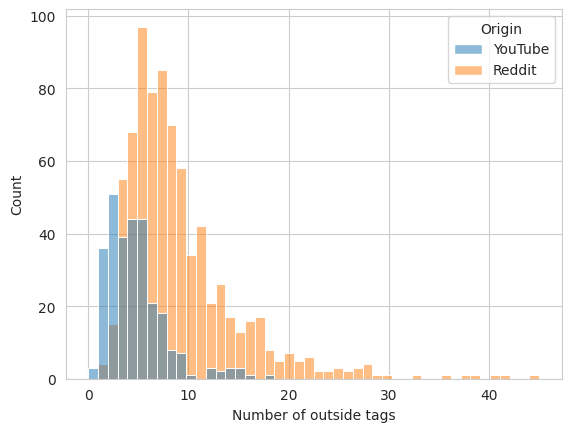

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.histplot(data_template, x="nO_tags", hue="Origin")
plt.xlabel("Number of outside tags")
plt.savefig("../figures/hist_outside_tokens_templates.pdf")
plt.show()


In [5]:
data_template

,id,set_id,Origin,TEXT,IOB,subset,yt_id,has_WoA,has_Artist,IOB_template,TEXT_template,O_tags,nO_tags
46,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,"[Artist, O, Artist, O, WoA]","[[Artist], &, [Artist], -, [WoA]]","[&, -]",2
79,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,"[WoA, O, WoA]","[[WoA], -, [WoA]]",[-],1
170,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1,hQz-aZH-ozU,True,True,"[Artist, O, WoA]","[[Artist], -, [WoA]]",[-],1
249,58_-cbPbDQhoyg,58.0,YouTube,"[i, cant, help, falling, in, love, -, enrico, ...","[B-WoA, I-WoA, I-WoA, I-WoA, I-WoA, I-WoA, O, ...",1,-cbPbDQhoyg,True,True,"[WoA, O, Artist]","[[WoA], -, [Artist]]",[-],1
367,81_kRssJvqEfzY,81.0,YouTube,"[spanish, harlem, -, alan, haven, and, tony, c...","[O, O, O, B-Artist, I-Artist, O, B-Artist, I-A...",1,kRssJvqEfzY,True,True,"[O, O, O, Artist, O, Artist, O, WoA]","[spanish, harlem, -, [Artist], and, [Artist], ...","[spanish, harlem, -, and, -]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,dataset4_739,12661.0,Reddit,"[looking, for, songs, similar, to, florida, ki...","[O, O, O, O, O, B-WoA, I-WoA, O, B-Artist, I-A...",2,739,True,True,"[O, O, O, O, O, WoA, O, Artist, O]","[looking, for, songs, similar, to, [WoA], (, [...","[looking, for, songs, similar, to, (, )]",7
2672,dataset4_743,12665.0,Reddit,"[gently, wind, |, joshua, speedy]","[B-WoA, I-WoA, O, B-Artist, I-Artist]",1,743,True,True,"[WoA, O, Artist]","[[WoA], |, [Artist]]",[|],1
2676,dataset4_746,12669.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",5,746,True,True,"[O, O, Artist, WoA, O]","[songs, like, [Artist], [WoA], ?]","[songs, like, ?]",3
2677,dataset4_747,12670.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",1,747,True,True,"[O, O, O, O, WoA, O, Artist]","[songs, /, artists, like, [WoA], by, [Artist]]","[songs, /, artists, like, by]",5


### Define functions for preprocessing, as in dataset

In [6]:
from typing import List
import sys
sys.path.append("../preprocessing")
from Processor import PerformerStringPreprocessor
from Utils import simplify_string, remove_bracket_with_one_content


def get_title_variations(s: str) -> List[str]:
    s = remove_bracket_with_one_content(s)
    l = s.split("/")
    l = [simplify_string(s) for s in l]
    return l

performer_processor = PerformerStringPreprocessor()

def get_performer_variations(s: str) -> List[str]:
    l = performer_processor.split_performers(s)
    l = [simplify_string(s) for s in l]
    l = performer_processor.article_preprocessing(l)
    return l

get_performer_variations("quentin tarantino feat. steven spielberg")


['quentin tarantino', 'steven spielberg']

### Loading additional info (Exoosure,Memorizationtest,Debut Artists)

#### Debut Artists

In [7]:
entity_dict = {}

data_debut = pd.read_json("../data/intermediate/debut_performers.jsonl", lines=True, orient="records")

list_postcutoff = []
for d in data_debut[["name", "release_title2"]].dropna().to_dict(orient="records"):
    d2 = {}
    d2["Artist"] = get_performer_variations(d["name"].lower())
    d2["WoA"] = get_title_variations(d["release_title2"].lower())
    list_postcutoff.append(d2)

entity_dict["post_cutoff"] = list_postcutoff
list_postcutoff[:5]


[{'Artist': ['kiradeer'], 'WoA': ['kiradeer']},
 {'Artist': ['the mackenzie dynamic', 'mackenzie dynamic'],
  'WoA': ['britparty']},
 {'Artist': ['ben keller'], 'WoA': ['fake you out']},
 {'Artist': ['dj durst'], 'WoA': ['dj durst early demos']},
 {'Artist': ['thistleblade'], 'WoA': ['forgotten north']}]

# Cloze
FMT refers to factual memorization test.
## Groups
- Unseen: 
    - Post Knowledge Cut
- (probably) unseen:
    - Not Memorized (FMT)
    - Low Exposure
- Seen:
    - Correct (FMT)
- (probably) seen:
    - Partial (FMT)
    - High Exposure

 # Strategies for generation
- Strategy 1: Cartesian
- Strategy 2: Sampling from group

In [8]:
data_template


,id,set_id,Origin,TEXT,IOB,subset,yt_id,has_WoA,has_Artist,IOB_template,TEXT_template,O_tags,nO_tags
46,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,"[Artist, O, Artist, O, WoA]","[[Artist], &, [Artist], -, [WoA]]","[&, -]",2
79,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,"[WoA, O, WoA]","[[WoA], -, [WoA]]",[-],1
170,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1,hQz-aZH-ozU,True,True,"[Artist, O, WoA]","[[Artist], -, [WoA]]",[-],1
249,58_-cbPbDQhoyg,58.0,YouTube,"[i, cant, help, falling, in, love, -, enrico, ...","[B-WoA, I-WoA, I-WoA, I-WoA, I-WoA, I-WoA, O, ...",1,-cbPbDQhoyg,True,True,"[WoA, O, Artist]","[[WoA], -, [Artist]]",[-],1
367,81_kRssJvqEfzY,81.0,YouTube,"[spanish, harlem, -, alan, haven, and, tony, c...","[O, O, O, B-Artist, I-Artist, O, B-Artist, I-A...",1,kRssJvqEfzY,True,True,"[O, O, O, Artist, O, Artist, O, WoA]","[spanish, harlem, -, [Artist], and, [Artist], ...","[spanish, harlem, -, and, -]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,dataset4_739,12661.0,Reddit,"[looking, for, songs, similar, to, florida, ki...","[O, O, O, O, O, B-WoA, I-WoA, O, B-Artist, I-A...",2,739,True,True,"[O, O, O, O, O, WoA, O, Artist, O]","[looking, for, songs, similar, to, [WoA], (, [...","[looking, for, songs, similar, to, (, )]",7
2672,dataset4_743,12665.0,Reddit,"[gently, wind, |, joshua, speedy]","[B-WoA, I-WoA, O, B-Artist, I-Artist]",1,743,True,True,"[WoA, O, Artist]","[[WoA], |, [Artist]]",[|],1
2676,dataset4_746,12669.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",5,746,True,True,"[O, O, Artist, WoA, O]","[songs, like, [Artist], [WoA], ?]","[songs, like, ?]",3
2677,dataset4_747,12670.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",1,747,True,True,"[O, O, O, O, WoA, O, Artist]","[songs, /, artists, like, [WoA], by, [Artist]]","[songs, /, artists, like, by]",5


In [9]:
import random


def fill_template_with_entities(template, entity_dict):
    filled_text = []
    new_iob = []
    used_entities = {key: [] for key in entity_dict.keys()}

    for token in template:
        if isinstance(token, str) and token.startswith('[') and token.endswith(']'):
            placeholder = token.strip('[]')  # Extract entity class name

            if placeholder in entity_dict:
                # Get a random, unused entity from the list for this placeholder
                available_entities = list(set(entity_dict[placeholder]) - set(used_entities[placeholder]))
                if available_entities:
                    chosen_entity = random.choice(available_entities)
                    used_entities[placeholder].append(chosen_entity)
                else:
                    # If we've exhausted all unique entities, re-use from the list
                    chosen_entity = random.choice(entity_dict[placeholder])

                # Tokenize the chosen entity mention
                entity_tokens = [t.lower() for t in chosen_entity.split()]

                # Replace the placeholder with the tokenized entity
                filled_text.extend(entity_tokens)

                # Create IOB tags for each token in the entity mention
                new_iob.append(f'B-{placeholder}')
                new_iob.extend([f'I-{placeholder}'] * (len(entity_tokens) - 1))

            elif placeholder == "YEAR":
                # Generate a random year between 1950 and 2023
                random_year = random.randint(1950, 2023)
                
                # Add the year as a token
                filled_text.append(str(random_year))
                
                # Add the 'O' tag since YEAR is an outside token
                new_iob.append('O')

            else:
                raise ValueError(f"Placeholder '{placeholder}' not found in entity_dict.")
        else:
            # It's a normal token, just append it with an 'O' tag
            filled_text.append(token)
            new_iob.append('O')

    return filled_text, new_iob

# sample example entity
cand_list = entity_dict["post_cutoff"]
ent = cand_list[random.randint(0, len(cand_list))]

# sample example template
template = data_template.TEXT_template.sample(1).item()

fill_template_with_entities(template=template, entity_dict=ent)


(['bloodcrusher',
  '-',
  'bloodcrusher',
  '[',
  'bloodcrusher',
  'cover',
  'version',
  ']'],
 ['B-Artist', 'O', 'B-WoA', 'O', 'B-Artist', 'O', 'O', 'O'])

### Original Template Data

In [10]:
import os
import sys
sys.path.append("..")
from preprocessing.Utils import write_biotag

output_path = "../data/dataset/reddit+shsyt_cloze"

write_biotag(data_template, os.path.join(output_path, "original.IOB") ,"IOB")


### Post cutoff template data

In [11]:
import pandas as pd
import random
import copy

random.seed(1)

def apply_fill_to_templates(data_template, entity_dict, group_key):
    # Helper function to fill a single row's template
    def fill_row_template(row):
        template = row['TEXT_template']  # The template to fill
        n_artists_needed = len([s for s in template if s == "[Artist]"])
        n_woas_needed = len([s for s in template if s == "[WoA]"])

        candidates = entity_dict[group_key]
        entity = copy.deepcopy(candidates[random.randint(0, len(candidates) - 1)])  # Copy the selected entity
        n_artists = len(entity.get("Artist")) if entity.get("Artist") else 0
        n_woa = len(entity.get("WoA")) if entity.get("WoA") else 0
        while n_artists < n_artists_needed or n_woa < n_woas_needed:
            other_entity = candidates[random.randint(0, len(candidates) - 1)]
            entity["Artist"] += other_entity["Artist"]
            entity["WoA"] += other_entity["WoA"]
            n_artists = len(entity["Artist"])
            n_woa = len(entity["WoA"])

        filled_text, IOBs = fill_template_with_entities(template, entity)
        return filled_text, IOBs  # Return the filled template as a string

    # Apply the function to every row and return a pandas Series with the filled templates
    filled_templates = data_template.apply(fill_row_template, axis=1)
    return filled_templates


# Syntehsize: Strategy 1 (1k templates + sampling from groups)

In [12]:
data_memorization = pd.read_json("../data/intermediate/shs100k2_memorization.jsonl", 
                                 lines=True, orient="records")

def string_to_tuple(s):
    return eval(s)

tuple_columns = [string_to_tuple(col) for col in data_memorization.columns]
data_memorization.columns = pd.MultiIndex.from_tuples(tuple_columns)

data_shs = pd.read_json("../data/raw/shs100k_metadata.jsonl", lines=True, orient="records")
data_shs = data_shs[["set_id", "work_id", "perf_id", "perf_artist", "perf_title"]].rename(
    columns={"perf_artist": "Artist", "perf_title": "WoA"}
)

current_columns = data_shs.columns
new_columns = pd.MultiIndex.from_product([current_columns, ['']])
data_shs.columns = new_columns
data_shs = data_shs.dropna(subset=[('Artist', ''), ( 'WoA', '')])
data_shs.WoA = data_shs.WoA.apply(lambda x: [random.sample(get_title_variations(x), 1)[0].lower()])
data_shs.Artist = data_shs.Artist.apply(lambda x: get_performer_variations(x))

data_memorization = pd.merge(data_memorization, data_shs, on=["set_id", "work_id", "perf_id"], how="left")


for model in data_memorization.columns.get_level_values(level=0).unique():
    try:
        mask_unseen = data_memorization.loc[:,[model]].T.sum() == 0
        mask_seen = data_memorization.loc[:,[(model, "AW1: Correct"),(model, "AW1: Correct")]].T.sum() == 2
        
        __data_seen = data_memorization.loc[mask_seen, ["Artist", "WoA"]]
        __data_seen.columns = ["Artist", "WoA"]
        entity_dict[f"fmt_{model}_seen"] = __data_seen.to_dict(orient="records")

        __data_unseen = data_memorization.loc[mask_unseen, ["Artist", "WoA"]]
        __data_unseen.columns = ["Artist", "WoA"]
        entity_dict[f"fmt_{model}_unseen"] = __data_unseen.to_dict(orient="records")
        
    except:
        # This is when multiindex does not refer to a model
        pass


/tmp/ipykernel_875007/1849360783.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data_memorization = pd.merge(data_memorization, data_shs, on=["set_id", "work_id", "perf_id"], how="left")


In [13]:

for key in entity_dict.keys():
# Call the function
    series = apply_fill_to_templates(data_template, entity_dict, key)
    write_biotag(pd.DataFrame(series.tolist(), columns=['TEXT', 'IOB']), os.path.join(output_path, key.lower() + ".IOB"),"IOB")


# Synthesize Strategy 2: Kartesian Product

In [33]:
output_path = "../data/dataset/reddit+shsyt_cloze_cartesian"

k=10
max_artists = data_template.TEXT_template.apply(lambda x: len([t for t in x if t == "[Artist]"])).max()
max_woas = data_template.TEXT_template.apply(lambda x: len([t for t in x if t == "[WoA]"])).max()
print(f"max. {max_artists} artists and max. {max_woas} WoAs per template needed")

entity_dict_small = {}

for key in entity_dict.keys():
    entity_dict_small[key] = {}
    entity_dict_small[key]["Artist"] = []
    entity_dict_small[key]["WoA"] = []
    candidates = random.sample([d for d in entity_dict[key] if d.get("WoA") and d.get("Artist")], k=k)
    for d in candidates:
        artist, woa = random.sample(d["Artist"], k=1)[0], random.sample(d["WoA"], k=1)[0]
        entity_dict_small[key]["Artist"].append(artist)
        entity_dict_small[key]["WoA"].append(woa)


max. 7 artists and max. 5 WoAs per template needed


In [34]:
# sample example entity
cand_list = entity_dict["post_cutoff"]
ent = cand_list[random.randint(0, len(cand_list))]

# sample example template
template = data_template.TEXT_template.sample(1).item()

def apply_fill_template(template, woa, artist, other_woas, other_artists):

    artists_needed = len([t for t in template if t == "[Artist]"])
    woas_needed = len([t for t in template if t == "[WoA]"])
    
    fill_artists, fill_woas = [artist], [woa]
    while artists_needed > len(fill_artists):
        fill_artists += random.sample(other_artists, k=1)

    while woas_needed > len(fill_woas):
        fill_woas += random.sample(other_woas, k=1)
        
    ent = {"Artist": fill_artists, "WoA": fill_woas}

    return fill_template_with_entities(template, ent)


for key in entity_dict_small:
    for i in range(k):
        artists, woas = entity_dict_small[key]["Artist"], entity_dict_small[key]["WoA"]
        artist, woa = artists[i], woas[i]
        other_artists = [artists[j] for j in range(len(artists)) if j != i]
        other_woas = [woas[j] for j in range(len(woas)) if j != i]

        series = data_template.TEXT_template.apply(
            lambda template: apply_fill_template(
                template=template, 
                woa=woa, artist=artist, 
                other_woas=other_woas,
                other_artists=other_artists))
        write_biotag(
            pd.DataFrame(series.tolist(), columns=['TEXT', 'IOB']), 
            os.path.join(output_path, key.lower() + f"_{i}.IOB"),"IOB")




In [29]:
pd.DataFrame(filled_templates, columns=["TEXT", "IOB"])

,TEXT,IOB


In [30]:
filled_templates

46      ([tom, waits, &, red, foley, -, san, diego, se...
79      ([never, be, anyone, else, but, you, -, san, d...
170     ([tom, waits, -, san, diego, serenade], [B-Art...
249     ([san, diego, serenade, -, tom, waits], [B-WoA...
367     ([spanish, harlem, -, tom, waits, and, orchest...
                              ...                        
2668    ([looking, for, songs, similar, to, san, diego...
2672    ([san, diego, serenade, |, tom, waits], [B-WoA...
2676    ([songs, like, tom, waits, san, diego, serenad...
2677    ([songs, /, artists, like, san, diego, serenad...
2680    ([looking, for, an, album, or, ep, in, cassett...
Name: TEXT_template, Length: 1058, dtype: object

In [24]:

data_template.TEXT_template

46                      [[Artist], &, [Artist], -, [WoA]]
79                                      [[WoA], -, [WoA]]
170                                  [[Artist], -, [WoA]]
249                                  [[WoA], -, [Artist]]
367     [spanish, harlem, -, [Artist], and, [Artist], ...
                              ...                        
2668    [looking, for, songs, similar, to, [WoA], (, [...
2672                                 [[WoA], |, [Artist]]
2676                    [songs, like, [Artist], [WoA], ?]
2677       [songs, /, artists, like, [WoA], by, [Artist]]
2680    [looking, for, an, album, or, ep, in, cassette...
Name: TEXT_template, Length: 1058, dtype: object

In [16]:
entity_dict_small


{'post_cutoff': {'Artist': ['madein',
   'satanic violence',
   'ultra towel police',
   'badvillain',
   'bodel',
   'flesh on stage',
   'smegma likker',
   'lysbaerer',
   'malicious combat',
   'veskraunghulthyr'],
  'WoA': ['sangseung',
   'six sick suck',
   'towel touch',
   'overstep',
   'bilan faller',
   'againstall session - 20240211 @ koenji db',
   'smegmalikker . bandcamp . com',
   'i : som et lys i natten , ma vi alle finde frelse',
   'the knock - out fulfilment',
   'lornmyr frost']},
 'fmt_Llama3.1-70B_seen': {'Artist': ['domenico modugno',
   'misfits',
   'clash',
   'la toya jackson',
   'tom jones',
   'london symphony orchestra',
   'major lance',
   'bon jovi',
   'icicle works',
   'marty robbins'],
  'WoA': ['io',
   'hybrid moments',
   'london calling',
   'baby love',
   'its not unusual',
   'the end',
   'the monkey time',
   'its my life',
   'should i stay or should i go ?',
   'i hang my head and cry']},
 'fmt_Llama3.1-70B_unseen': {'Artist': ['luigi

In [17]:
entity_dict["post_cutoff"]

[{'Artist': ['kiradeer'], 'WoA': ['kiradeer']},
 {'Artist': ['the mackenzie dynamic', 'mackenzie dynamic'],
  'WoA': ['britparty']},
 {'Artist': ['ben keller'], 'WoA': ['fake you out']},
 {'Artist': ['dj durst'], 'WoA': ['dj durst early demos']},
 {'Artist': ['thistleblade'], 'WoA': ['forgotten north']},
 {'Artist': ['appalachian anarchy'], 'WoA': ['banjo bloodbath']},
 {'Artist': ['ai dungeon'],
  'WoA': ['fables , odes , overtures , lore , & serenades']},
 {'Artist': ['ba5il'], 'WoA': ['the h suite']},
 {'Artist': ['infinity'], 'WoA': ['1 : erstschlag i - drei atomsprengkopfe']},
 {'Artist': ['is : sue'], 'WoA': ['connect']},
 {'Artist': ['rescene'], 'WoA': ['yoyo']},
 {'Artist': ['automacar'], 'WoA': ['cookies']},
 {'Artist': ['unis'], 'WoA': ['we unis']},
 {'Artist': ['nullpolitik'], 'WoA': ['probe demo']},
 {'Artist': ['nek !'], 'WoA': ['get over']},
 {'Artist': ['a concubine between traps', 'concubine between traps'],
  'WoA': ['canciones para demostrar de los vylleros , los curi

### Exposure Popular Template Data

In [18]:
data_exposure = pd.read_json("../data/intermediate/shs100k2_exposure.jsonl", lines=True, orient="records")


In [19]:
data_memorization[["set_id", "work_id", "perf_id"]]

,set_id,work_id,perf_id
,,,
0,0,4681,132979
1,1,7895,7895
2,2,7896,86970
3,3,12959,507152
4,4,312438,51032
...,...,...,...
10282,9992,97193,97193
10283,9992,97193,97194
10284,9993,9750,9750


# Perturbation

In [20]:
import random

def perturb_characters(text, num_chars_to_perturb):
    """
    Perturb a specific number of characters in the input text.
    
    Args:
        text (str): The original text to perturb.
        num_chars_to_perturb (int): The number of characters to perturb.
        
    Returns:
        str: The perturbed text.
    """
    characters = list(text)
    text_length = len(characters)

    if num_chars_to_perturb > text_length:
        num_chars_to_perturb = text_length

    for _ in range(num_chars_to_perturb):
        perturbation_type = random.choice(["substitution", "deletion", "insertion"])
        index = random.randint(0, len(characters) - 1)
        
        if perturbation_type == "substitution":
            # Replace the character with a random one
            characters[index] = random.choice("abcdefghijklmnopqrstuvwxyz-./_=")
        elif perturbation_type == "deletion" and len(characters) > 1:
            # Remove the character
            characters.pop(index)
        elif perturbation_type == "insertion":
            # Insert a random character
            characters.insert(index, random.choice("abcdefghijklmnopqrstuvwxyz-./="))
    
    return ''.join(characters)


def perturb_tokens(text, perturbation_strength=0.1):
    """
    Perturb tokens in the input text.
    
    Args:
        text (str): The original text to perturb.
        perturbation_strength (float): The proportion of tokens to perturb (0 to 1).
        
    Returns:
        str: The perturbed text.
    """
    tokens = text.split()
    num_perturbations = int(len(tokens) * perturbation_strength)
    
    for _ in range(num_perturbations):
        perturbation_type = random.choice(["substitution", "deletion", "shuffle"])
        index = random.randint(0, len(tokens) - 1)
        
        if perturbation_type == "substitution":
            # Replace the token with a random one (for simplicity, replacing with "RANDOM" token)
            tokens[index] = "RANDOM"
        elif perturbation_type == "deletion" and len(tokens) > 1:
            # Remove the token
            tokens.pop(index)
        elif perturbation_type == "shuffle" and len(tokens) > 1:
            # Shuffle the token with another random token
            swap_index = random.randint(0, len(tokens) - 1)
            tokens[index], tokens[swap_index] = tokens[swap_index], tokens[index]
    
    return ' '.join(tokens)



In [21]:
perturb_characters("The beatles", num_chars_to_perturb=1)


'Thme beatles'

In [22]:
# Example usage
text = "This is an example text."
perturbed_text = perturb_tokens(text, perturbation_strength=0.2)
print(perturbed_text)



RANDOM is an example text.
